## Loading data

In [34]:
#imports

from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import sklearn 
import numpy as np 
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import altair_ally as aly
import altair as alt
from xgboost import XGBRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv("data/raw/marketing-campaign-dataset.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df

,campaign_item_id,no_of_days,time,ext_service_id,ext_service_name,creative_id,creative_width,creative_height,search_tags,template_id,...,exchange_rate,media_cost_usd,position_in_content,unique_reach,total_reach,search_tag_cat,cmi_currency_code,timezone,weekday_cat,keywords
61363,3213,12,2022-10-05,4,Google Ads,12055,300.0,250.0,#Embrace Your Individuality with X,90.0,...,1,0.840377,NaN,NaN,NaN,Inmarket,AED,Asia/Kolkata,week_day,elegant jewelry
47729,3188,6,2022-10-27,4,Google Ads,9760,300.0,250.0,#Timeless X Style,93.0,...,1,0.494350,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,seashell jewelry
29541,3159,20,2022-11-10,16,DV360,6520,300.0,250.0,#Be Bold. Be X,90.0,...,1,0.983223,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,choker necklaces
44783,3182,24,2022-11-10,16,DV360,9025,300.0,250.0,#The X Factor - Fashion for the Fearless,90.0,...,1,0.478502,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,chic jewelry
70821,3101,14,2022-09-01,128,Facebook Ads,14395,NaN,NaN,#The X Factor - Fashion for the Fearless,NaN,...,1,73.994587,NaN,NaN,NaN,Others,INR,Asia/Kolkata,week_day,mixed metal jewelry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63206,3216,31,2022-10-24,16,DV360,12560,300.0,250.0,#Timeless X Style,90.0,...,1,1.192337,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,affordable jewelry
61404,3213,20,2022-10-13,128,Facebook Ads,12060,300.0,250.0,#Be Bold. Be X,90.0,...,1,0.720463,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,summer jewelry
17730,3053,10,2022-09-02,16,DV360,3620,300.0,250.0,#Be Bold. Be X,90.0,...,1,75.348995,NaN,NaN,NaN,Others,INR,Asia/Kolkata,week_day,seasonal jewelry
28030,3155,6,2022-08-22,128,Facebook Ads,6085,300.0,250.0,#Embrace Your Individuality with X,90.0,...,1,0.836557,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,winter jewelry


### Checking for null values

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58089 entries, 61363 to 15725
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   campaign_item_id     58089 non-null  int64  
 1   no_of_days           58089 non-null  int64  
 2   time                 58089 non-null  object 
 3   ext_service_id       58089 non-null  int64  
 4   ext_service_name     58089 non-null  object 
 5   creative_id          58089 non-null  int64  
 6   creative_width       55360 non-null  float64
 7   creative_height      55360 non-null  float64
 8   search_tags          58089 non-null  object 
 9   template_id          55360 non-null  float64
 10  landing_page         58089 non-null  object 
 11  advertiser_id        58089 non-null  int64  
 12  advertiser_name      58089 non-null  object 
 13  network_id           58089 non-null  int64  
 14  approved_budget      57764 non-null  float64
 15  advertiser_currency  58089 non-null  

### Dropping the features with many nulls

In [4]:
train_df.describe()

,campaign_item_id,no_of_days,ext_service_id,creative_id,creative_width,creative_height,template_id,advertiser_id,network_id,approved_budget,...,max_bid_cpm,network_margin,campaign_budget_usd,impressions,clicks,exchange_rate,media_cost_usd,position_in_content,unique_reach,total_reach
count,58089.000000,58089.000000,58089.000000,58089.000000,55360.000000,55360.000000,55360.000000,58089.000000,58089.000000,5.776400e+04,...,5931.0,58089.0,58089.000000,58089.000000,58089.000000,58089.0,58089.000000,0.0,0.0,0.0
mean,3130.429307,27.081788,49.235208,7457.306030,267.875723,223.229769,83.097038,6195.601043,345.305204,1.258295e+05,...,1.0,0.0,615.413188,1359.975710,51.734683,1.0,11.699501,NaN,NaN,NaN
std,142.190135,25.504700,55.807791,4067.185725,92.765670,77.304725,20.829073,387.884293,23.618505,5.610207e+05,...,0.0,0.0,1322.528288,3673.828631,377.507459,0.0,47.896793,NaN,NaN,NaN
min,2733.000000,0.000000,4.000000,1000.000000,0.000000,0.000000,23.000000,4756.000000,188.000000,4.000000e+02,...,1.0,0.0,2.452316,511.000000,2.000000,1.0,0.000000,NaN,NaN,NaN
25%,3148.000000,9.000000,4.000000,3725.000000,300.000000,250.000000,90.000000,6319.000000,353.000000,6.000000e+03,...,1.0,0.0,208.566757,526.000000,5.000000,1.0,0.433215,NaN,NaN,NaN
50%,3173.000000,19.000000,16.000000,7885.000000,300.000000,250.000000,90.000000,6385.000000,353.000000,1.000000e+04,...,1.0,0.0,378.027248,577.000000,8.000000,1.0,1.707308,NaN,NaN,NaN
75%,3202.000000,37.000000,128.000000,11005.000000,300.000000,250.000000,90.000000,6394.000000,353.000000,1.500000e+04,...,1.0,0.0,755.313351,816.000000,13.000000,1.0,8.278085,NaN,NaN,NaN
max,3960.000000,118.000000,128.000000,15605.000000,300.000000,250.000000,93.000000,6490.000000,353.000000,6.000000e+06,...,1.0,0.0,39559.896155,153959.000000,31807.000000,1.0,2295.028945,NaN,NaN,NaN


### Column data types and first few rows

In [5]:
train_df.nunique()

campaign_item_id         157
no_of_days               119
time                     224
ext_service_id             3
ext_service_name           3
creative_id             2878
creative_width             2
creative_height            2
search_tags                6
template_id                5
landing_page              45
advertiser_id             47
advertiser_name           44
network_id                 6
approved_budget           61
advertiser_currency        5
channel_id                 5
channel_name               5
max_bid_cpm                1
network_margin             1
campaign_budget_usd      696
impressions             5892
clicks                  1136
stats_currency             5
currency_code              5
exchange_rate              1
media_cost_usd         57529
position_in_content        0
unique_reach               0
total_reach                0
search_tag_cat             5
cmi_currency_code          5
timezone                   7
weekday_cat                2
keywords      

### Distributions

In [6]:
import altair as alt
import vegafusion
alt.data_transformers.enable("vegafusion")


numeric_cols = train_df.select_dtypes("number").columns.tolist()
numeric_cols_dist = alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type = "quantitative", bin = alt.Bin(maxbins = 20)),
    y ="count()",
).properties(
        width = 250,
        height = 150
).repeat(
    numeric_cols,
    columns = 3
)

numeric_cols_dist

alt.RepeatChart(...)

### Distribution of categorical columns

In [7]:
cat_cols = list(train_df.select_dtypes("object").columns.drop('time'))

categorical_cols_dist = alt.Chart(train_df).mark_bar().encode(
    x=alt.X(alt.repeat("repeat"), type="nominal"),
    y="count()",
).properties(
    width=550,
    height=150
).repeat(
    repeat=cat_cols,
    columns=1
)

categorical_cols_dist

alt.RepeatChart(...)

In [8]:
def missing_zero_values_table(df):

    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
           "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
    return mz_table
missing_zero_values_table(train_df)

Your selected dataframe has 35 columns and 58089 Rows.
There are 8 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
position_in_content,0,58089,100.0,58089,100.0,float64
unique_reach,0,58089,100.0,58089,100.0,float64
total_reach,0,58089,100.0,58089,100.0,float64
max_bid_cpm,0,52158,89.8,52158,89.8,float64
creative_width,5928,2729,4.7,8657,14.9,float64
creative_height,5928,2729,4.7,8657,14.9,float64
template_id,0,2729,4.7,2729,4.7,float64
approved_budget,0,325,0.6,325,0.6,float64


In [9]:
aly.corr(train_df)

alt.ConcatChart(...)

Text(0.5, 1.0, 'Service name vs clicks')

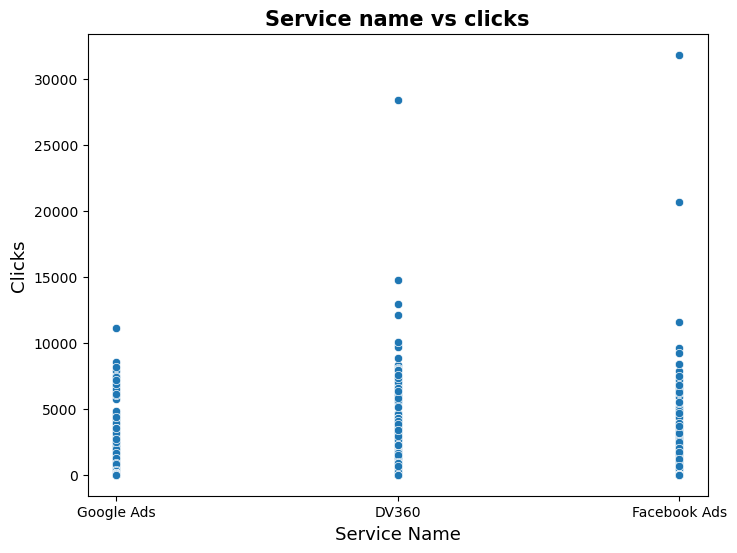

In [10]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='ext_service_name', y='clicks', data=train_df)

plt.xlabel("Service Name", size=13)
plt.ylabel("Clicks", size=13)
plt.title("Service name vs clicks",size=15, weight='bold')

Text(0.5, 1.0, 'Channel name vs clicks')

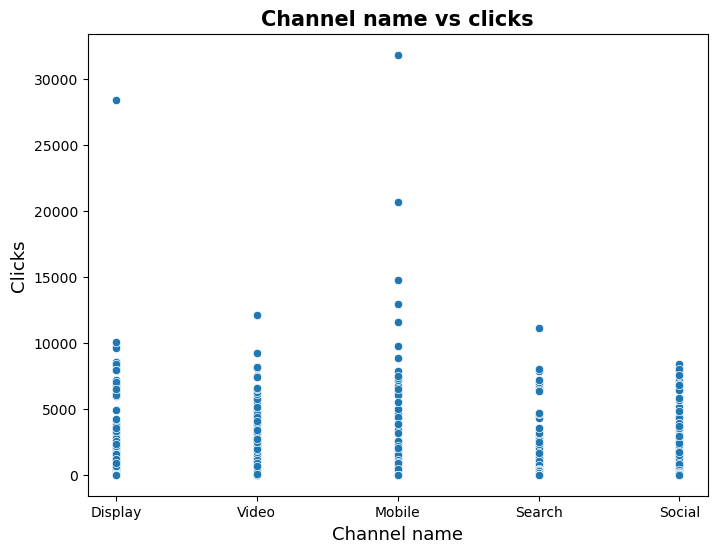

In [11]:

plt.figure(figsize=(8,6))
sns.scatterplot(x='channel_name', y='clicks', data=train_df)

plt.xlabel("Channel name", size=13)
plt.ylabel("Clicks", size=13)
plt.title("Channel name vs clicks",size=15, weight='bold')

## Preprocessing

In [12]:
train_df['creative_width'].fillna(train_df['creative_width'].mean(), inplace=True)
train_df['creative_height'].fillna(train_df['creative_height'].mean(), inplace=True)
train_df['approved_budget'].fillna(train_df['approved_budget'].mean(), inplace=True)
test_df['creative_width'].fillna(test_df['creative_width'].mean(), inplace=True)
test_df['creative_height'].fillna(test_df['creative_height'].mean(), inplace=True)
test_df['approved_budget'].fillna(test_df['approved_budget'].mean(), inplace=True)


X_train = train_df.drop(columns=['clicks'])
y_train = train_df['clicks']
X_test = test_df.drop(columns=['clicks'])
y_test = test_df['clicks']


categorical_features = [
    'ext_service_name', 
    'search_tags',
    'advertiser_name',
    'channel_name',
    'search_tag_cat',
    'keywords',
    'campaign_item_id',
    'creative_id',
    'template_id',
    'landing_page',
    'network_id'
]


numeric_features = [
    'no_of_days', 
    'creative_width', 
    'creative_height', 
    'approved_budget',
    'campaign_budget_usd',
    'impressions',
    'media_cost_usd'
]


drop_features = [
    'timezone',
    'weekday_cat',
    'time', 
    'ext_service_id', 
    'advertiser_id',
    'channel_id',
    'max_bid_cpm',
    'network_margin',
    'advertiser_currency',
    'currency_code',
    'exchange_rate',
    'stats_currency',
    'position_in_content',
    'unique_reach', 
    'total_reach',
    'cmi_currency_code'
]
    

In [13]:
numeric_transformer = make_pipeline(
    StandardScaler()
)

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features), 
    ('drop', drop_features)
)

In [14]:
# dummy model
model_dummy = DummyRegressor()

pipe_dummy = make_pipeline(preprocessor, model_dummy)

cv_df = pd.DataFrame(cross_validate(pipe_dummy, 
                                    X_train, 
                                    y_train, 
                                    return_train_score=True,
                                    scoring='r2'
))
cv_df

,fit_time,score_time,test_score,train_score
0,0.073804,0.015904,-5.238245e-05,0.0
1,0.069617,0.014597,-1.286987e-04,0.0
2,0.069435,0.014705,-1.260176e-05,0.0
3,0.068163,0.014409,-5.288284e-09,0.0
4,0.069794,0.014389,-1.458942e-04,0.0


In [15]:
# Linear Model  
pipe_ridge = make_pipeline(preprocessor, Ridge())

cv_df = pd.DataFrame(cross_validate(pipe_ridge, X_train, y_train, scoring='r2', return_train_score=True, cv=10))
cv_df

cross_val_results = {}
cross_val_results['ridge'] = cv_df.agg(['mean', 'std']).round(3).T
cross_val_results['ridge']

,mean,std
fit_time,0.243,0.012
score_time,0.009,0.000
test_score,0.593,0.160
train_score,0.592,0.025


In [16]:
# 2. Hyperparameter tuning 

param_dist = {"ridge__alpha": 10.0**np.arange(-5, 5) }

random_search = RandomizedSearchCV(
    pipe_ridge, 
    param_dist, 
    n_iter=100, 
    return_train_score=True, 
    random_state=123,
    n_jobs=-1 ,
    scoring='r2', 
    cv=5
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['no_of_days',
                                                                                'creative_width',
                                                                                'creative_height',
                                                                                'approved_budget',
                                                                                'campaign_budget_usd',
                                                                                'impressions',
                                                                                'media_cost_usd']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEnco...
                                                                                'advertiser_currency',
                                                                                'currency_code',
                                                                                'exchange_rate',
                                                                                'stats_currency',
                                                                                'position_in_content',
                                                                                'unique_reach',
                                                                                'total_reach',
                                                                                'cmi_currency_code'])])),
                                             ('ridge', Ridge())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'ridge__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])},
                   random_state=123, return_train_score=True, scoring='r2')

In [17]:
best_params = random_search.best_params_
best_r2 = random_search.best_score_

print("Best alpha:", best_params)
print("best score:", best_r2)

Best alpha: {'ridge__alpha': 1.0}
best score: 0.5824058408997608


In [18]:
# Randomforest
pipe_rf = make_pipeline(
    preprocessor,
    RandomForestRegressor(max_depth=10, random_state=123)
    )

cv_rf = pd.DataFrame(cross_validate(pipe_rf, X_train, y_train, cv = 5, return_train_score = True))
cv_rf

,fit_time,score_time,test_score,train_score
0,17.403745,0.059646,0.568415,0.919232
1,17.419941,0.058341,0.723051,0.913525
2,17.773519,0.059127,0.510115,0.909871
3,17.688262,0.059480,0.620789,0.907273
4,17.482254,0.058988,0.768297,0.911137


In [19]:
cross_val_results['randomforest'] = cv_rf.agg(['mean', 'std']).round(3).T
cross_val_results['randomforest']

,mean,std
fit_time,17.554,0.167
score_time,0.059,0.001
test_score,0.638,0.107
train_score,0.912,0.005


In [20]:
pipe_rf.fit(X_train, y_train)
model_rf = pipe_rf.named_steps['randomforestregressor']

In [21]:
feature_importances_rf = model_rf.feature_importances_
feature_importances_rf
feature_names_1 = pipe_rf.named_steps['columntransformer'].named_transformers_['pipeline-1'].get_feature_names_out().tolist()
feature_names_2 = pipe_rf.named_steps['columntransformer'].named_transformers_['pipeline-2'].get_feature_names_out().tolist()

feature_names = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_rf})
feature_importances_rf_sorted = feature_importance_df.sort_values(by='Importance', ascending = False).head(10)
feature_importances_rf_sorted

,Feature,Importance
5,impressions,0.481192
6,media_cost_usd,0.084284
0,no_of_days,0.072748
782,creative_id_3200,0.060089
4,campaign_budget_usd,0.034766
2973,creative_id_14240,0.024837
3258,landing_page_https://www.abcjewelry.com/collec...,0.023649
122,keywords_fall jewelry,0.022944
3002,creative_id_14395,0.013736
3075,creative_id_14785,0.013388


In [22]:
#XGBoost
pipe_xgb = make_pipeline(
    preprocessor,
    XGBRegressor(
        random_state=123, verbosity=0))
cv_df_xg = pd.DataFrame(cross_validate(pipe_xgb, X_train, y_train, cv = 5, return_train_score = True))
cv_df_xg

,fit_time,score_time,test_score,train_score
0,0.306419,0.020575,0.740745,0.989215
1,0.271803,0.020962,0.671559,0.989463
2,0.272223,0.020643,0.697355,0.987350
3,0.274595,0.019722,0.829965,0.988892
4,0.267767,0.023015,0.813132,0.987689


In [23]:
cross_val_results['XGBoost'] = cv_df_xg.agg(['mean', 'std']).round(3).T
cross_val_results['XGBoost']

,mean,std
fit_time,0.279,0.016
score_time,0.021,0.001
test_score,0.751,0.070
train_score,0.989,0.001


In [35]:
param_dist = {
    'xgbregressor__n_estimators': randint(50, 500),
    'xgbregressor__learning_rate': uniform(0.01, 0.2),
    'xgbregressor__max_depth': randint(3, 10)
}

random_search = RandomizedSearchCV(
    pipe_xgb, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    random_state=123,
    verbose=1
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print("Best parameters:", best_params)

best_model = random_search.best_estimator_

cv_df_xg = pd.DataFrame(cross_validate(best_model, X_train, y_train, cv=5, return_train_score=True))
print(cv_df_xg)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'xgbregressor__learning_rate': 0.20852272520253282, 'xgbregressor__max_depth': 8, 'xgbregressor__n_estimators': 203}
   fit_time  score_time  test_score  train_score
0  0.696738    0.034454    0.752622     0.997457
1  0.725209    0.034155    0.709423     0.997287
2  0.917531    0.059454    0.736113     0.996995
3  0.822784    0.047388    0.854341     0.996765
4  0.735252    0.032535    0.835902     0.996968


In [36]:
cross_val_results['XGBoost-optimized'] = cv_df_xg.agg(['mean', 'std']).round(3).T
cross_val_results['XGBoost-optimized']

,mean,std
fit_time,0.780,0.090
score_time,0.042,0.012
test_score,0.778,0.064
train_score,0.997,0.000


In [43]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Define your pipeline with feature selection
pipe_xgb_fs = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(XGBRegressor(random_state=123))),
    ('xgbregressor', XGBRegressor(random_state=123, verbosity=0))
])

# Parameter distribution for RandomizedSearchCV
param_dist_fs = {
    'feature_selector__estimator__n_estimators': randint(50, 150),
    'feature_selector__estimator__max_depth': randint(3, 7),
    'feature_selector__threshold': ["mean", "median", "1.25*mean", "2*mean"],  # Thresholds for feature selection
    'xgbregressor__n_estimators': randint(50, 150),
    'xgbregressor__max_depth': randint(3, 7),
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1],
    'xgbregressor__subsample': [0.6, 0.7, 0.8, 0.9],
    'xgbregressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'xgbregressor__min_child_weight': randint(1, 6),
    'xgbregressor__gamma': [0, 0.1, 0.2, 0.3],
    'xgbregressor__reg_alpha': [0, 0.1, 0.5, 1],
    'xgbregressor__reg_lambda': [1, 1.5, 2, 3]
}

# Configure RandomizedSearchCV
random_search_fs = RandomizedSearchCV(
    estimator=pipe_xgb_fs,
    param_distributions=param_dist_fs,
    n_iter=100,  # Lower the number of iterations for faster computation on a laptop
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=123,
    verbose=1
)

# Fit RandomizedSearchCV
random_search_fs.fit(X_train, y_train)

# Get the best parameters and estimator
best_params_fs = random_search_fs.best_params_
best_model_fs = random_search_fs.best_estimator_

# Perform cross-validation with the best model
cv_df_xg_fs = pd.DataFrame(cross_validate(best_model_fs, X_train, y_train, cv=5, return_train_score=True))
print(cv_df_xg_fs)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
   fit_time  score_time  test_score  train_score
0  0.458184    0.022743    0.666628     0.973774
1  0.477484    0.022739    0.656989     0.963417
2  0.499712    0.026409    0.766921     0.965438
3  0.526087    0.023029    0.854944     0.971194
4  0.506110    0.022358    0.837701     0.970871


In [44]:
cross_val_results['XGBoost-optimized-normalized'] = cv_df_xg.agg(['mean', 'std']).round(3).T
cross_val_results['XGBoost-optimized-normalized']

,mean,std
fit_time,0.780,0.090
score_time,0.042,0.012
test_score,0.778,0.064
train_score,0.997,0.000


In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import pandas as pd
from scipy.stats import uniform, randint

# Define the pipeline with Ridge regression for feature selection
pipe_xgb_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(Ridge())),
    ('xgbregressor', XGBRegressor(random_state=123, verbosity=0))
])

# Parameter distribution for RandomizedSearchCV, with stronger regularization
param_dist_ridge = {
    'feature_selector__estimator__alpha': uniform(1, 100),  # Increase Ridge regularization strength
    'feature_selector__threshold': ["mean", "median", "1.25*mean", "2*mean"],
    'xgbregressor__n_estimators': [50, 100, 150],
    'xgbregressor__max_depth': [3, 4],  # Reduce max depth to limit model complexity
    'xgbregressor__learning_rate': [0.01, 0.05],  # Lower learning rates can help reduce overfitting
    'xgbregressor__subsample': [0.7, 0.8],  # Subsampling to add stochasticity
    'xgbregressor__colsample_bytree': [0.7, 0.8],
    'xgbregressor__min_child_weight': [3, 4, 5],  # Increase this to reduce overfitting
    'xgbregressor__gamma': [0.1, 0.2, 0.3],
    'xgbregressor__reg_alpha': [0.5, 1, 1.5],  # Increase L1 regularization
    'xgbregressor__reg_lambda': [1, 2, 3]  # Increase L2 regularization
}

# Configure RandomizedSearchCV with n_jobs=-1 to use all available CPU cores
random_search_ridge = RandomizedSearchCV(
    estimator=pipe_xgb_ridge,
    param_distributions=param_dist_ridge,
    n_iter=100,  # Adjust the number of iterations as needed
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available CPU cores
    random_state=123,
    verbose=1
)

# Fit RandomizedSearchCV
random_search_ridge.fit(X_train, y_train)

# Get the best parameters and estimator
best_params_ridge = random_search_ridge.best_params_
best_model_ridge = random_search_ridge.best_estimator_

# Perform cross-validation with the best model, also with n_jobs=-1
cv_df_xg_ridge = pd.DataFrame(cross_validate(
    best_model_ridge, X_train, y_train, cv=5, 
    return_train_score=True, n_jobs=-1
))
print(cv_df_xg_ridge)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
   fit_time  score_time  test_score  train_score
0  0.364820    0.037057    0.514799     0.820100
1  0.384382    0.036025    0.717095     0.780905
2  0.366198    0.038384    0.611422     0.777891
3  0.396808    0.035652    0.630895     0.786598
4  0.375605    0.033023    0.765568     0.793075


In [52]:
cross_val_results['XGBoost-optimized-normalized-ridge-select'] = cv_df_xg.agg(['mean', 'std']).round(3).T
cross_val_results['XGBoost-optimized-normalized-ridge-select']

,mean,std
fit_time,0.780,0.090
score_time,0.042,0.012
test_score,0.778,0.064
train_score,0.997,0.000


In [53]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBRegressor
import pandas as pd
from scipy.stats import uniform, randint

# Define a CV strategy
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=123)

# Define the pipeline with RFECV for feature selection
pipe_xgb_rfecv = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', RFECV(estimator=XGBRegressor(random_state=123, verbosity=0), 
                               step=1, 
                               cv=cv_strategy, 
                               scoring='neg_mean_squared_error', 
                               n_jobs=-1)),
    ('xgbregressor', XGBRegressor(random_state=123, verbosity=0))
])

# Parameter distribution for RandomizedSearchCV, focusing on hyperparameters that control overfitting
param_dist_rfecv = {
    'xgbregressor__n_estimators': randint(50, 150),
    'xgbregressor__max_depth': randint(3, 7),
    'xgbregressor__learning_rate': uniform(0.01, 0.1),
    'xgbregressor__subsample': uniform(0.5, 0.5),
    'xgbregressor__colsample_bytree': uniform(0.5, 0.5),
    'xgbregressor__min_child_weight': randint(1, 6),
    'xgbregressor__gamma': uniform(0, 0.5),
    'xgbregressor__reg_alpha': uniform(0, 1),
    'xgbregressor__reg_lambda': uniform(1, 3)
}

# Configure RandomizedSearchCV with n_jobs=-1 to use all available CPU cores
random_search_rfecv = RandomizedSearchCV(
    estimator=pipe_xgb_rfecv,
    param_distributions=param_dist_rfecv,
    n_iter=10,  # Adjust the number of iterations as needed
    cv=cv_strategy,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available CPU cores
    random_state=123,
    verbose=1
)

# Fit RandomizedSearchCV
random_search_rfecv.fit(X_train, y_train)

# Get the best parameters and estimator
best_params_rfecv = random_search_rfecv.best_params_
best_model_rfecv = random_search_rfecv.best_estimator_

# Perform cross-validation with the best model, also with n_jobs=-1
cv_df_xg_rfecv = pd.DataFrame(cross_validate(
    best_model_rfecv, X_train, y_train, cv=cv_strategy, 
    return_train_score=True, n_jobs=-1
))
print(cv_df_xg_rfecv)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
cross_val_results['XGBoost-optimized-normalized-rfecv'] = cv_df_xg.agg(['mean', 'std']).round(3).T
cross_val_results['XGBoost-optimized-normalized-rfecv']

In [24]:
pipe_xgb.fit(X_train, y_train)
model_xg = pipe_xgb.named_steps['xgbregressor']

In [25]:
feature_importances_xgb = model_xg.feature_importances_
feature_importances_xgb
feature_names_1 = pipe_xgb.named_steps['columntransformer'].named_transformers_['pipeline-1'].get_feature_names_out().tolist()
feature_names_2 = pipe_xgb.named_steps['columntransformer'].named_transformers_['pipeline-2'].get_feature_names_out().tolist()

feature_names = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_xgb})
feature_importances_xgb_sorted = feature_importance_df.sort_values(by='Importance', ascending = False).head(10)
feature_importances_xgb_sorted

,Feature,Importance
782,creative_id_3200,0.181433
2973,creative_id_14240,0.086068
214,campaign_item_id_3050,0.070596
2982,creative_id_14290,0.069947
236,campaign_item_id_3131,0.047309
835,creative_id_3470,0.043983
4,campaign_budget_usd,0.043331
3002,creative_id_14395,0.034708
5,impressions,0.030737
47,advertiser_name_Pan India,0.022419


In [26]:
#lightgbm

pipe_lgbm = make_pipeline(
    preprocessor, LGBMRegressor(random_state=123)
)
cv_df_lgbm = pd.DataFrame(cross_validate(pipe_lgbm, X_train, y_train, cv = 5, return_train_score = True))
cv_df_lgbm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3645
[LightGBM] [Info] Number of data points in the train set: 46471, number of used features: 1352
[LightGBM] [Info] Start training from score 52.136214
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3652
[LightGBM] [Info] Number of data points in the train set: 46471, number of used features: 1355
[LightGBM] [Info] Start training from score 50.892234
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

,fit_time,score_time,test_score,train_score
0,0.535687,0.024015,0.621304,0.802706
1,0.478066,0.023153,0.725313,0.828268
2,0.480755,0.024788,0.593127,0.823200
3,0.472099,0.024658,0.598566,0.811475
4,0.479933,0.022977,0.757144,0.795801


In [27]:
cross_val_results['LGBMRegressor'] = cv_df_lgbm.agg(['mean', 'std']).round(3).T
cross_val_results['LGBMRegressor']

,mean,std
fit_time,0.489,0.026
score_time,0.024,0.001
test_score,0.659,0.077
train_score,0.812,0.014


In [28]:
pipe_lgbm.fit(X_train, y_train)
model_lgbm = pipe_lgbm.named_steps['lgbmregressor']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3993
[LightGBM] [Info] Number of data points in the train set: 58089, number of used features: 1526
[LightGBM] [Info] Start training from score 51.734683


In [29]:
feature_importances_lgbm = model_lgbm.feature_importances_
feature_names_1 = pipe_lgbm.named_steps['columntransformer'].named_transformers_['pipeline-1'].get_feature_names_out().tolist()
feature_names_2 = pipe_lgbm.named_steps['columntransformer'].named_transformers_['pipeline-2'].get_feature_names_out().tolist()

feature_names = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_lgbm})
feature_importances_lgbm_sorted = feature_importance_df.sort_values(by='Importance', ascending = False).head(10)
feature_importances_lgbm_sorted

,Feature,Importance
0,no_of_days,549
4,campaign_budget_usd,437
5,impressions,361
6,media_cost_usd,242
3,approved_budget,221
782,creative_id_3200,79
1,creative_width,61
35,advertiser_name_Kuala Lumpur,37
214,campaign_item_id_3050,35
34,advertiser_name_Karnataka,34


In [30]:
pd.concat(cross_val_results, axis = 1)

ridge        randomforest        XGBoost        LGBMRegressor  \
              mean    std         mean    std    mean    std          mean   
fit_time     0.243  0.012       17.554  0.167   0.279  0.016         0.489   
score_time   0.009  0.000        0.059  0.001   0.021  0.001         0.024   
test_score   0.593  0.160        0.638  0.107   0.751  0.070         0.659   
train_score  0.592  0.025        0.912  0.005   0.989  0.001         0.812   

                    
               std  
fit_time     0.026  
score_time   0.001  
test_score   0.077  
train_score  0.014

In [32]:
rfecv = RFECV(Ridge(), n_jobs=-1)

pipe_rf_rfecv = make_pipeline(
    preprocessor, rfecv, LGBMRegressor(random_state=123)
)
cv_df_rfecv = pd.DataFrame(cross_validate(pipe_rf_rfecv, X_train, y_train,cv = 5, return_train_score = True))


KeyboardInterrupt: 

In [ ]:
pipe_rf_rfecv.fit(X_train, y_train)

In [ ]:
rfecv_fs = pipe_rf_rfecv.named_steps["rfecv"]
rfecv_fs.n_features_


In [ ]:
cross_val_results['RFECV'] = cv_df_rfecv.agg(['mean', 'std']).round(3).T
cross_val_results['RFECV']

In [ ]:
pd.concat(cross_val_results, axis = 1)

In [ ]:

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

param_dist = {
    'lgbmregressor__learning_rate': uniform(loc=0.01, scale=0.3),
    'lgbmregressor__num_leaves': randint(24, 80),
    'lgbmregressor__max_depth': randint(3, 15),
}

random_search = RandomizedSearchCV(estimator=pipe_lgbm, param_distributions=param_dist,
                                   n_iter=100, scoring='r2', cv=5, n_jobs=-1, random_state=123)

random_search.fit(X_train, y_train)

In [ ]:
print("Best Parameters:", random_search.best_params_)

In [ ]:
print("Best Score:", random_search.best_score_)